## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [65]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
# Opening JSON file
jsonFile = "/content/drive/MyDrive/data/NLP/Customer_complaint/complaints-2021-05-14_08_16.json"

# returns JSON object as
# a dictionary
with open(jsonFile, 'r') as file:
    data = json.load(file)

df=pd.json_normalize(data)

## Data preparation

In [68]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [69]:
df.shape

(78313, 22)

In [70]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

Only one column (_score) has number data


In [72]:
#Assign new column names

#List of columns
column_names = df.columns.tolist()
#Remove _ and _source.
new_column_names = [col[1:] if col.startswith("_") else col for col in column_names]
new_column_names = [col.replace("source.", "") for col in new_column_names]

df.columns = new_column_names
print(new_column_names)

['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [73]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [74]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace("", np.nan)


In [75]:
nan_count = df['complaint_what_happened'].isnull().sum()
print(nan_count)

57241


#### There are lot of complaints with No Text





In [76]:
#Remove all rows where complaints column is nan
df_cleaned = df.dropna(subset=['complaint_what_happened'])
df_cleaned.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [77]:
# Write your function here to clean the text and remove all the unnecessary elements.
import re
import string
def clean_complaints_text(text):
    # Make the text lowercase
    text = text.lower()

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove words containing numbers
    text = ' '.join(word for word in text.split() if not any(c.isdigit() for c in word))

    return text

In [78]:
df_cleaned_new= pd.DataFrame(df_cleaned['complaint_what_happened'].apply(clean_complaints_text))
print(df_cleaned_new)

                                 complaint_what_happened
1      good morning my name is xxxx xxxx and i apprec...
2      i upgraded my xxxx xxxx card in and was told b...
10     chase card was reported on however fraudulent ...
11     on while trying to book a xxxx xxxx ticket i c...
14     my grand son give me check for i deposit it in...
...                                                  ...
78303  after being a chase card customer for well ove...
78309  on wednesday xxxxxxxx i called chas my xxxx xx...
78310  i am not familiar with xxxx pay and did not un...
78311  i have had flawless credit for yrs ive had cha...
78312  roughly years ago i closed out my accounts wit...

[21072 rows x 1 columns]


### Remove Duplicates

In [79]:
df_cleaned_new['complaint_what_happened'].describe()


count                                                 21072
unique                                                20871
top       chase has violated usc by continuing collectio...
freq                                                     11
Name: complaint_what_happened, dtype: object

In [80]:
df_cleaned_new = df_cleaned_new.drop_duplicates()
df_final = df_cleaned_new.reset_index(drop=True)


In [81]:
df_final['complaint_what_happened'].describe()


count                                                 20871
unique                                                20871
top       good morning my name is xxxx xxxx and i apprec...
freq                                                      1
Name: complaint_what_happened, dtype: object

In [82]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Get part-of-speech tags for each token
    pos_tags = nltk.pos_tag(tokens)

    # Map POS tags to WordNet tags
    wn_tags = {
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV,
        'J': wordnet.ADJ
    }

    # Lemmatize tokens using their POS tags
    lemmatized_tokens = [lemmatizer.lemmatize(token, wn_tags.get(pos[0], wordnet.NOUN)) for token, pos in pos_tags]

    # Join the lemmatized tokens back into a sentence
    lemmatized_text = ' '.join(lemmatized_tokens)

    return lemmatized_text

# def lemmatizer(text):
#     # Initialize empty list to store lemmas
#     sent = []

#     # Extract lemmas of given text and add to the list 'sent'
#     doc = nlp(text)
#     for word in doc:
#         sent.append(word.lemma_)

#     # return string converted form of the list of lemmas
#     return " ".join(sent)


In [83]:
df_final["lemmatized_complaint"] =  df_final.apply(lambda x: lemmatize_text(x['complaint_what_happened']), axis=1)
df_clean = df_final

#df_final["lemmatized_complaint"] =  df_final.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)




In [84]:
df_clean = df_final

# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaint
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [85]:
#As i am not using Spacy, we can replace -PRON- and will  be removed in next stage
def replace_pronouns_with_PRON(text):
    doc = nlp(text)
    replaced_text = " ".join(["-PRON-" if token.tag_ == "PRP" else token.lemma_ for token in doc])
    return replaced_text

In [86]:
df_clean["complaint_POS_PRON"] = df_clean["lemmatized_complaint"].apply(replace_pronouns_with_PRON)


In [87]:
df_clean.head(3)

,complaint_what_happened,lemmatized_complaint,complaint_POS_PRON
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and -PRON- a...
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,-PRON- upgrade my xxxx xxxx card in and be tel...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card be report on however fraudulent app...


Seems it is lematized done well, and we an observer  ,  ,

*   wrote -> write
*   sent -> send
*   asking -> ask

,etc.

In [88]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_PRON
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and -PRON- a...
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,-PRON- upgrade my xxxx xxxx card in and be tel...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card be report on however fraudulent app...
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,on while try to book a xxxx xxxx ticket -PRON-...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,my grand son give -PRON- check for -PRON- depo...
...,...,...,...
20866,after being a chase card customer for well ove...,after be a chase card customer for well over a...,after be a chase card customer for well over a...
20867,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...,on wednesday xxxxxxxx -PRON- call chas my xxxx...
20868,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,-PRON- be not familiar with xxxx pay and do no...
20869,i have had flawless credit for yrs ive had cha...,i have have flawless credit for yrs ive have c...,-PRON- have have flawless credit for yrs -PRON...


In [89]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [90]:
#Write your function to extract the POS tags
from nltk.tokenize import word_tokenize
from nltk import pos_tag

def extract_nouns(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    nouns_only = [word for word, tag in pos_tags if tag == 'NN']
    return ' '.join(nouns_only)

# Apply the extract_pos_tags function to the "complaint_what_happened" column
df_clean["complaint_POS_removed"] = df_clean["complaint_POS_PRON"].apply(extract_nouns)


In [91]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(3)

,complaint_what_happened,lemmatized_complaint,complaint_POS_PRON,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and -PRON- a...,morning name -PRON- stop bank cardmember servi...
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,-PRON- upgrade my xxxx xxxx card in and be tel...,-PRON- card agent upgrade date agent informati...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card be report on however fraudulent app...,card report application identity consent servi...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




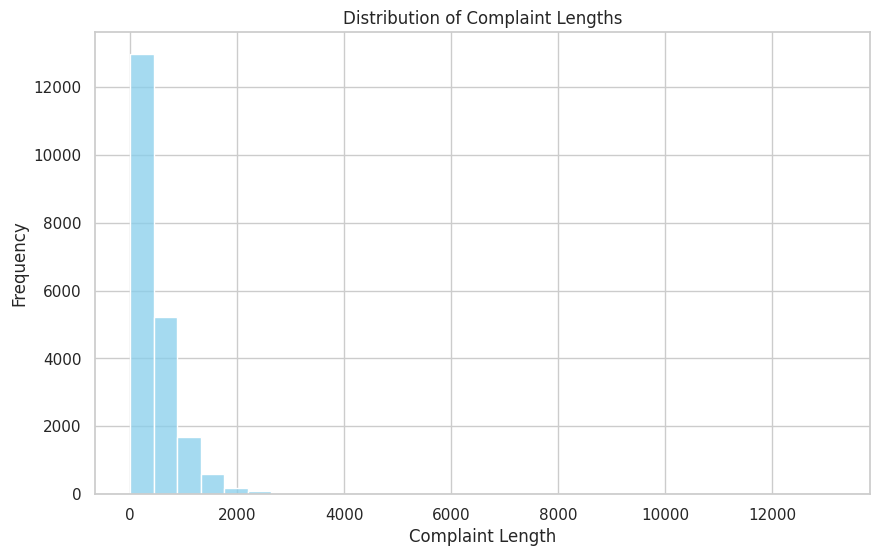

In [92]:
# Write your code here to visualise the data according to the 'Complaint' character length

import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for Seaborn
sns.set(style="whitegrid")

# Calculate complaint lengths
complaint_lens = [len(d) for d in df_clean['complaint_POS_removed']]

# Create a histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=complaint_lens, bins=30, kde=False, color='skyblue')
plt.xlabel('Complaint Length')
plt.ylabel('Frequency')
plt.title('Distribution of Complaint Lengths')
plt.show()



#### Find the top 40 words by frequency among all the articles after processing the text.

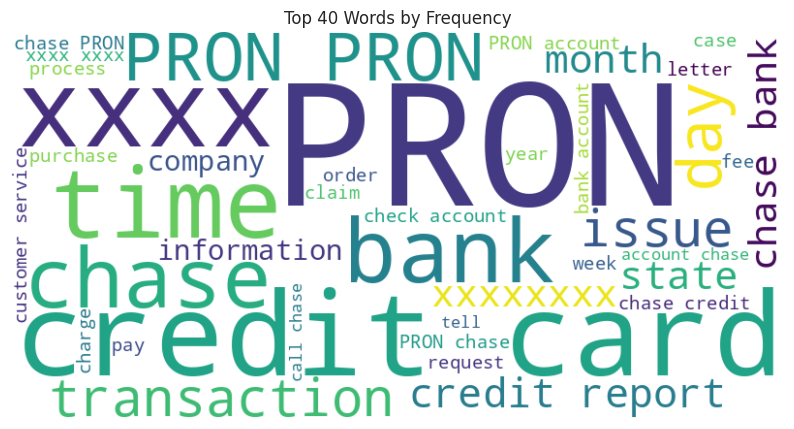

In [93]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

# Combine all the processed texts into a single string
all_text = ' '.join(df_clean['complaint_POS_removed'])

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(all_text)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words by Frequency')
plt.show()

In [94]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [95]:
df_clean.head(3)

,complaint_what_happened,lemmatized_complaint,complaint_POS_PRON,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and -PRON- a...,morning name -PRON- stop bank cardmember servi...,morning name stop bank cardmember service ask...
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,-PRON- upgrade my xxxx xxxx card in and be tel...,-PRON- card agent upgrade date agent informati...,card agent upgrade date agent information ord...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [96]:
from collections import Counter

#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
all_text = ' '.join(df_clean['Complaint_clean'])

# Tokenize the text into words
words = all_text.split()

# Calculate the frequency of each word using Counter
word_freq = Counter(words)

# Create a DataFrame to store the word frequencies
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Display the top 30 unigram frequencies
top_unigrams = word_freq_df.head(30)

In [97]:
#Print the top 10 words in the unigram frequency
top_unigrams.head(10)

,Frequency
chase,49705
account,47383
credit,33806
xxxx,31999
card,29138
bank,28461
payment,21067
time,16001
charge,15467
call,14762


In [98]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer instance to extract bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=30)

# Fit and transform the complaints to get the bigram counts
bigram_counts = vectorizer.fit_transform(df_clean["Complaint_clean"])

# Get the feature names (bigram words)
bigram_words = vectorizer.get_feature_names_out()

# Sum up the counts of each bigram
bigram_frequencies = bigram_counts.sum(axis=0)

# Create a dictionary of bigram frequencies
bigram_frequency_dict = {word: freq for word, freq in zip(bigram_words, bigram_frequencies.tolist()[0])}

# Sort the bigram frequencies in descending order
sorted_bigram_frequencies = sorted(bigram_frequency_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top 30 bigram frequencies
for bigram, freq in sorted_bigram_frequencies[:30]:
    print(f"{bigram}: {freq}")


credit card: 12716
credit report: 3878
chase bank: 3343
check account: 3227
customer service: 3073
chase credit: 3013
xxxx xxxx: 2973
bank account: 2612
account chase: 2378
call chase: 2340
chase account: 2268
account account: 1905
phone call: 1672
account bank: 1576
debit card: 1551
credit score: 1535
card account: 1486
account credit: 1316
contact chase: 1309
interest rate: 1290
credit bureau: 1246
business day: 1245
phone number: 1238
money account: 1220
payment payment: 1172
account number: 1151
credit account: 1149
charge account: 1147
card chase: 1140
card company: 1098


In [99]:
#Print the top 10 words in the bigram frequency
sorted_bigram_frequencies[:10]

[('credit card', 12716),
 ('credit report', 3878),
 ('chase bank', 3343),
 ('check account', 3227),
 ('customer service', 3073),
 ('chase credit', 3013),
 ('xxxx xxxx', 2973),
 ('bank account', 2612),
 ('account chase', 2378),
 ('call chase', 2340)]

In [100]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).

#Same as above Range 3,3
vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=30)

trigram_counts = vectorizer.fit_transform(df_clean["Complaint_clean"])

trigram_words = vectorizer.get_feature_names_out()

trigram_frequencies = trigram_counts.sum(axis=0)

trigram_frequency_dict = {word: freq for word, freq in zip(trigram_words, trigram_frequencies.tolist()[0])}

sorted_trigram_frequencies = sorted(trigram_frequency_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top 30 trigram frequencies
for trigram, freq in sorted_trigram_frequencies[:30]:
    print(f"{trigram}: {freq}")


chase credit card: 2105
credit card account: 984
credit card company: 978
credit card chase: 553
inquiry credit report: 454
credit card credit: 431
charge credit card: 413
chase customer service: 389
credit reporting agency: 376
account credit card: 357
bank credit card: 338
credit card bank: 337
card credit card: 328
credit reporting act: 314
credit report credit: 307
credit card payment: 277
credit card charge: 273
xxxx xxxx xxxx: 273
chase check account: 266
xxxx credit card: 266
call customer service: 264
chase fraud department: 253
account credit report: 249
credit card balance: 248
check account chase: 246
consumer protection bureau: 245
freedom credit card: 230
credit card service: 229
check account bank: 228
victim identity theft: 226


In [ ]:
#Print the top 10 words in the trigram frequency
sorted_trigram_frequencies[:10]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [101]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean.head(5)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [102]:
#Write your code here to initialise the TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [103]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [104]:
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer



## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [105]:
tfidf_vectorizer = TfidfVectorizer(max_features=100)
# # Fit and transform the text data to get the TF-IDF matrix
# tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])

In [106]:
#Load your nmf_model with the n_components i.e 5

# # Create a range of potential cluster numbers
# cluster_range = range(2, 21)

# # Initialize an empty list to store silhouette scores
# silhouette_scores = []

# # Iterate over cluster numbers
# for num_clusters in cluster_range:
#     nmf_model = NMF(n_components=num_clusters, random_state=42)
#     nmf_matrix = nmf_model.fit_transform(dtm)
#     labels = nmf_matrix.argmax(axis=1)
#     silhouette_scores.append(silhouette_score(nmf_matrix, labels))

# # Find the cluster number with the highest silhouette score
# best_cluster_num = cluster_range[silhouette_scores.index(max(silhouette_scores))]

# #keep the random_state =40
# nmf_model = NMF(n_components=best_cluster_num, random_state=40)
# nmf_matrix = nmf_model.fit_transform(dtm)

# # Get the top words for each cluster
# #num_top_words = 10
# feature_names = tfidf_vectorizer.get_feature_names_out()
# word_clusters = []
# for topic_idx, topic in enumerate(nmf_model.components_):
#     top_words = [feature_names[i] for i in topic.argsort()[:-num_topics - 1:-1]]
#     word_clusters.append(top_words)


# nmf_model = #write your code here

# Create and fit the NMF model
num_topics = 5
max_iter = 1000
nmf_model = NMF(n_components=num_topics, max_iter=max_iter, random_state=40)
nmf_model.fit(dtm)

NMF(max_iter=1000, n_components=5, random_state=40)

In [ ]:
#nmf_model.fit(dtm)
num_features = dtm.get_shape()[1]
print("Number of Features:", num_features)
# feature_names = tfidf_vectorizer.get_feature_names_out()
# num_features = len(feature_names)
# ##len(tfidf.get_feature_names())
# print(num_features)
# print(feature_names)

In [107]:
#Print the Top15 words for each of the topics
feature_names = tfidf.get_feature_names_out()
top_feature_indices = nmf_model.components_.argsort()[:, -15:]
for topic_idx, top_features in enumerate(top_feature_indices):
    print(f"Topic {topic_idx}: {', '.join(feature_names[i] for i in top_features)}")








Topic 0: customer, claim, transfer, transaction, business, number, day, branch, deposit, chase, fund, money, bank, check, account
Topic 1: year, letter, application, debt, bureau, information, limit, company, score, account, chase, inquiry, report, card, credit
Topic 2: sale, foreclosure, house, bank, document, time, rate, letter, year, property, modification, chase, home, mortgage, loan
Topic 3: company, statement, time, refund, service, fraud, claim, purchase, merchant, transaction, fee, chase, dispute, card, charge
Topic 4: mortgage, year, chase, account, credit, date, auto, time, day, pay, statement, fee, month, balance, payment


In [108]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([2, 1, 1, ..., 3, 4, 4])

In [109]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [110]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_PRON,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and -PRON- a...,morning name -PRON- stop bank cardmember servi...,morning name stop bank cardmember service ask...,2
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,-PRON- upgrade my xxxx xxxx card in and be tel...,-PRON- card agent upgrade date agent informati...,card agent upgrade date agent information ord...,1
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,on while try to book a xxxx xxxx ticket -PRON-...,try book xxxx ticket offer ticket apply card p...,try book ticket offer ticket apply card put i...,1
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,my grand son give -PRON- check for -PRON- depo...,son check deposit -PRON- chase account fund ba...,son check deposit chase account fund bank acc...,0


### Drop some columns for better visibility of data

In [111]:
columns_to_drop = ['complaint_POS_PRON', 'complaint_POS_removed']
df_clean = df_clean.drop(columns=columns_to_drop)

In [112]:
#Print the first 5 Complaint for each of the Topics
df_clean5 = df_clean.groupby('Topic').head(5)

df_clean5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,Complaint_clean,Topic
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check deposit chase account fund bank acc...,0
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday branch cus...,0
10,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,mishandle account auto,0
12,i opened an account with chase bank on xxxx an...,i open an account with chase bank on xxxx and ...,account bank code bonus call term everything ...,0
15,i opened the saving account for the bonus i wa...,i open the save account for the bonus i be sup...,save account bonus bonus auto transfer check...,0
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information ord...,1
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,1
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,try book ticket offer ticket apply card put i...,1
5,can you please remove inquiry,can you please remove inquiry,inquiry,1
9,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [113]:
# topic_4_rows = df_clean[df_clean['Topic'] == 3]
# pd.set_option('display.max_colwidth', None)

# topic_4_rows["complaint_what_happened"] = topic_4_rows["complaint_what_happened"].str.strip()
# print(topic_4_rows["complaint_what_happened"])

In [114]:
# topic_4_rows = df_clean[df_clean['Topic'] == 4]

# topic_4_rows["complaint_what_happened"] = topic_4_rows["complaint_what_happened"].str.strip()
# print(topic_4_rows["complaint_what_happened"])

In [115]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card",
               2:"Mortgage/Loan",
               3:"Theft/Dispute Reporting",
               4:"Others"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [116]:
df_clean.head(5)

,complaint_what_happened,lemmatized_complaint,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask...,Mortgage/Loan
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information ord...,Credit card or prepaid card
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,Credit card or prepaid card
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,try book ticket offer ticket apply card put i...,Credit card or prepaid card
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check deposit chase account fund bank acc...,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [117]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services": 0,
               "Credit card or prepaid card": 1,
               "Mortgage/Loan":2,
               "Theft/Dispute Reporting":3,
               "Others":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [118]:
df_clean.head(3)

,complaint_what_happened,lemmatized_complaint,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask...,2
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information ord...,1
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,1


In [119]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
columns_to_drop = ['lemmatized_complaint', 'Complaint_clean']
training_data= df_clean.drop(columns=columns_to_drop)

In [120]:
training_data.head(3)

,complaint_what_happened,Topic
0,good morning my name is xxxx xxxx and i apprec...,2
1,i upgraded my xxxx xxxx card in and was told b...,1
2,chase card was reported on however fraudulent ...,1


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [121]:
training_data.shape

(20871, 2)

In [122]:
training_data['Topic'].value_counts()

0    5086
1    4931
3    4924
2    3711
4    2219
Name: Topic, dtype: int64

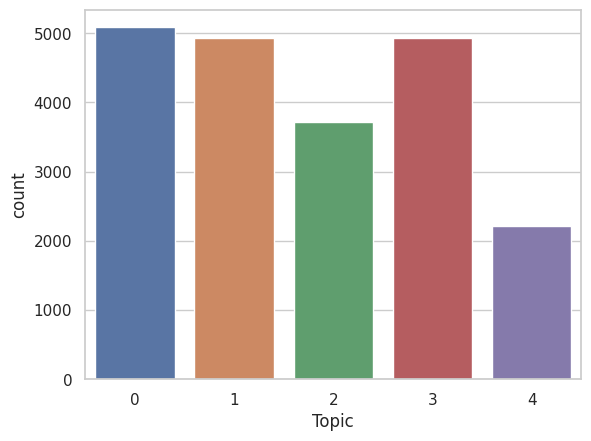

In [123]:
sns.countplot(x='Topic', data=training_data)
plt.show()

In [126]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaint_what_happened'])


#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [127]:
# Save the Vector and TF-IDF
import pickle
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [128]:
# Test and Train Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print("Shape of Train and Test Split")
print("X_train :",X_train.shape)
print("y_train :",y_train.shape)

print("X_test :",X_test.shape)
print("y_test :",y_test.shape)

Shape of Train and Test Split
X_train : (15653, 33599)
y_train : (15653,)
X_test : (5218, 33599)
y_test : (5218,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Logistic Regression

In [130]:
lpo# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")


# Create a Logistic Regression model
logreg_model = LogisticRegression()

# Fit the model on the training data
logreg_model.fit(X_train, y_train)

# Predict using the test data
y_pred = logreg_model.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print("F1 Score Using Logistic Regression:", f1)


F1 Score In Logistic Regression: 0.9247087880508759


### Decision Trees

In [131]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree classifier
dtree_model = DecisionTreeClassifier()

# Fit the model on the training data
dtree_model.fit(X_train, y_train)

# Predict using the test data
y_pred = dtree_model.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print("F1 Score Using Decision Tree:", f1)

F1 Score Using Decision Tree: 0.7895767200455556


### Random Forest

In [132]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_model = RandomForestClassifier()

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict using the test data
y_pred = rf_model.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print("F1 Score Using Random Forest:", f1)

F1 Score Using Random Forest: 0.8151436743980819


## Comparision


*   Logistic Regression  : 0.9247087880508759
*   Decision Tree        : 0.7895767200455556
*   Random Forest        : 0.8151436743980819

Seems  Logistic Regression is perfroming well in this data, lets Optimize this for better results





In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
logreg_model = LogisticRegression()

# Define the hyperparameter grid to search over
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2','elasticnet'],
    'solver': ['liblinear','saga'],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='f1_weighted')

# Fit the model using the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best estimator
best_logreg_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_logreg_model.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print("Best F1 Score:", f1)
print("Best Hyperparameters:", grid_search.best_params_)

Best F1 Score: 0.9462951153905304
Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}


#### Now Lets rund the Logistic Regression with Best Hyperparameters Predicted

In [135]:
final_logreg_model = LogisticRegression(C=1, penalty='l1', solver='saga')

# Fit the model on the training data
final_logreg_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = final_logreg_model.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print("Best F1 Score in Final Model :", f1)



Best F1 Score in Final Model : 0.9464870176054982


In [136]:
# Save Final model

pickle.dump(final_logreg_model, open("final_logreg_model.pkl", "wb"))

## Now Lets predict with this Model

In [137]:
# Funcation to predict

def predict_topic(text):

    target_names = ["Bank Account services",
                    "Credit card or prepaid card",
                    "Mortgage/Loan",
                    "Theft/Dispute Reporting",
                    "Others"]

    # Load the CountVectorizer with the pre-trained vocabulary
    loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    # Load the TF-IDF vectorizer with the pre-trained transformation
    loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))

    # Finally Load the pre-trained Logistic Regression model
    loaded_model = pickle.load(open("final_logreg_model.pkl","rb"))

    # Transform the input text into counts using the loaded CountVectorizer
    X_new_counts = loaded_vec.transform(text)
    # Transform  and Predict
    X_new_tfidf = loaded_tfidf.transform(X_new_counts)
    predicted = loaded_model.predict(X_new_tfidf)

    return target_names[predicted[0]]

In [141]:
# Create a dataframe  with sample complaints

df_test = pd.DataFrame({'Sample Complaints': ["Yesterday, I received a fraudulent email regarding renewal of my services. and asking for my OTP",
                                              "I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "What is the procedure to know my Credi Score how to get better score"]})
df_test

,Sample Complaints
0,"Yesterday, I received a fraudulent email regar..."
1,I can not get from chase who services my mortg...
2,The bill amount of my credit card was debited ...
3,I want to open a salary account at your downto...
4,What is the procedure to know my Credi Score h...


In [142]:
df_test['predicted topic'] = df_test['Sample Complaints'].apply(lambda x: predict_topic([x]))
df_test

,Sample Complaints,predicted topic
0,"Yesterday, I received a fraudulent email regar...",Theft/Dispute Reporting
1,I can not get from chase who services my mortg...,Mortgage/Loan
2,The bill amount of my credit card was debited ...,Credit card or prepaid card
3,I want to open a salary account at your downto...,Bank Account services
4,What is the procedure to know my Credi Score h...,Credit card or prepaid card


## That will be our final model predictions , Seems performaing very well